# Wintertime Flux Dynamics: Diurnal Patterns, Atmospheric Controls, and Anthropogenic Signals

## Overview

This notebook analyzes eddy covariance flux data collected over the UIC urban flux tower to investigate:

- **Temporal patterns** of CO₂, H₂O, and sensible heat fluxes
- **Impact of atmospheric stability and turbulence** on flux magnitudes and variability
- **Anthropogenic signatures**, such as weekday/weekend and rush hour effects
- **Environmental filtering**, highlighting conditions of cold air temperature and low water vapor mixing ratio
- **Decoupling between carbon and water fluxes**, especially under winter combustion influence

We apply statistical normalization techniques and condition-based filtering to isolate **mechanistic drivers** and enhance the interpretability of flux dynamics under **urban cold-season constraints**.

---

The workflow includes:
- Seasonal and daily z-score normalization of fluxes
- Diurnal composite plots for various meteorological and social conditions
- Stability (L) and turbulence (u*) class-based comparisons
- CO₂-H₂O decoupling index visualization
- Summary statistics for cold, dry, and weekend conditions

This analysis supports flux partitioning efforts and attribution of **boundary layer trace gas behavior** to both **biogenic** and **anthropogenic sources** during winter in urban environments.


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:

file_dir = "/Users/bhupendra/projects/crocus/data/flux_data/data/netcdf/resnc/"
file_list = [os.path.join(root, f) for root, _, files in os.walk(file_dir) for f in files if f.endswith('.nc')]
ds = xr.open_mfdataset(file_list)
ds

<xarray.Dataset> Size: 16MB
Dimensions:                        (time: 15004)
Coordinates:
  * time                           (time) datetime64[ns] 120kB 2024-07-01T00:...
Data variables: (12/115)
    filename                       (time) <U34 2MB dask.array<chunksize=(48,), meta=np.ndarray>
    DOY                            (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    daytime                        (time) int64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    file_records                   (time) int64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    used_records                   (time) int64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    Tau                            (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    ...                             ...
    w_per_h2o_cov                  (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    vin_sf_mean                    (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    co2_mean                       (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    h2o_mean                       (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    dew_point_mean                 (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
    co2_signal_strength_7500_mean  (time) float64 120kB dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/27)
    site_name:              UIC
    altitude:               178.5
    latitude:               41.86945343
    longitude:              -87.64586639
    station_name:           CROCUS
    logger_id:              smart3-00694
    ...                     ...
    funding_source:         U.S. DOE Office of Science, Biological and Enviro...
    acknowledgment:         This material is based upon work supported by the...
    file_creation_date:     2024-11-04
    data_version:           v1.0.0
    file_version:           2024.11.04
    doi:                    10.15485/2473253

In [3]:
# Define variables of interest
variables = [
    'air_temperature', 'h2o_mixing_ratio', 'h2o_flux', 'H', 'co2_flux',
    'u*', 'L', 'VPD', 'RH', 'bowen_ratio'
]

# Convert xarray.Dataset to pandas DataFrame
df = ds[variables].to_dataframe().reset_index()

# Add useful time columns
df['date'] = pd.to_datetime(df['time']).dt.date
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['month'] = pd.to_datetime(df['time']).dt.month
df['weekday'] = pd.to_datetime(df['time']).dt.weekday
df['is_weekend'] = df['weekday'] >= 5


In [4]:
# Custom pastel red and blue (can override Seaborn pastel if needed)
color_palette = {
    'Weekday': '#D81B60',  # pastel blue
    'Weekend': '#004D40'   # pastel red
}

## Normalized Flux Anomaly Composites

In [5]:
# Compute daily means and std deviations
for var in ['h2o_flux', 'H', 'co2_flux']:
    daily_mean = df.groupby('date')[var].transform('mean')
    daily_std = df.groupby('date')[var].transform('std')
    df[f'{var}_anomaly'] = (df[var] - daily_mean) / daily_std


### Normalized using daily mean and SD

In [6]:
# Step 1: Filter winter and subset by condition
df['season'] = 'Winter'
df.loc[~df['month'].isin([12, 1, 2]), 'season'] = 'Other'

# Filter to DJF only
df_winter = df[df['season'] == 'Winter'].copy()

# Define cold and dry subsets
df_cold = df_winter[df_winter['air_temperature'] < 273]
df_dry = df_winter[df_winter['h2o_mixing_ratio'] < 5]

# Preview counts
print("Cold readings:", len(df_cold))
print("Dry readings:", len(df_dry))


Cold readings: 2444
Dry readings: 3009


#### Diurnal Anomaly Panels – Daily Normalization

These plots show z-scored flux anomalies normalized by each day's mean and standard deviation.

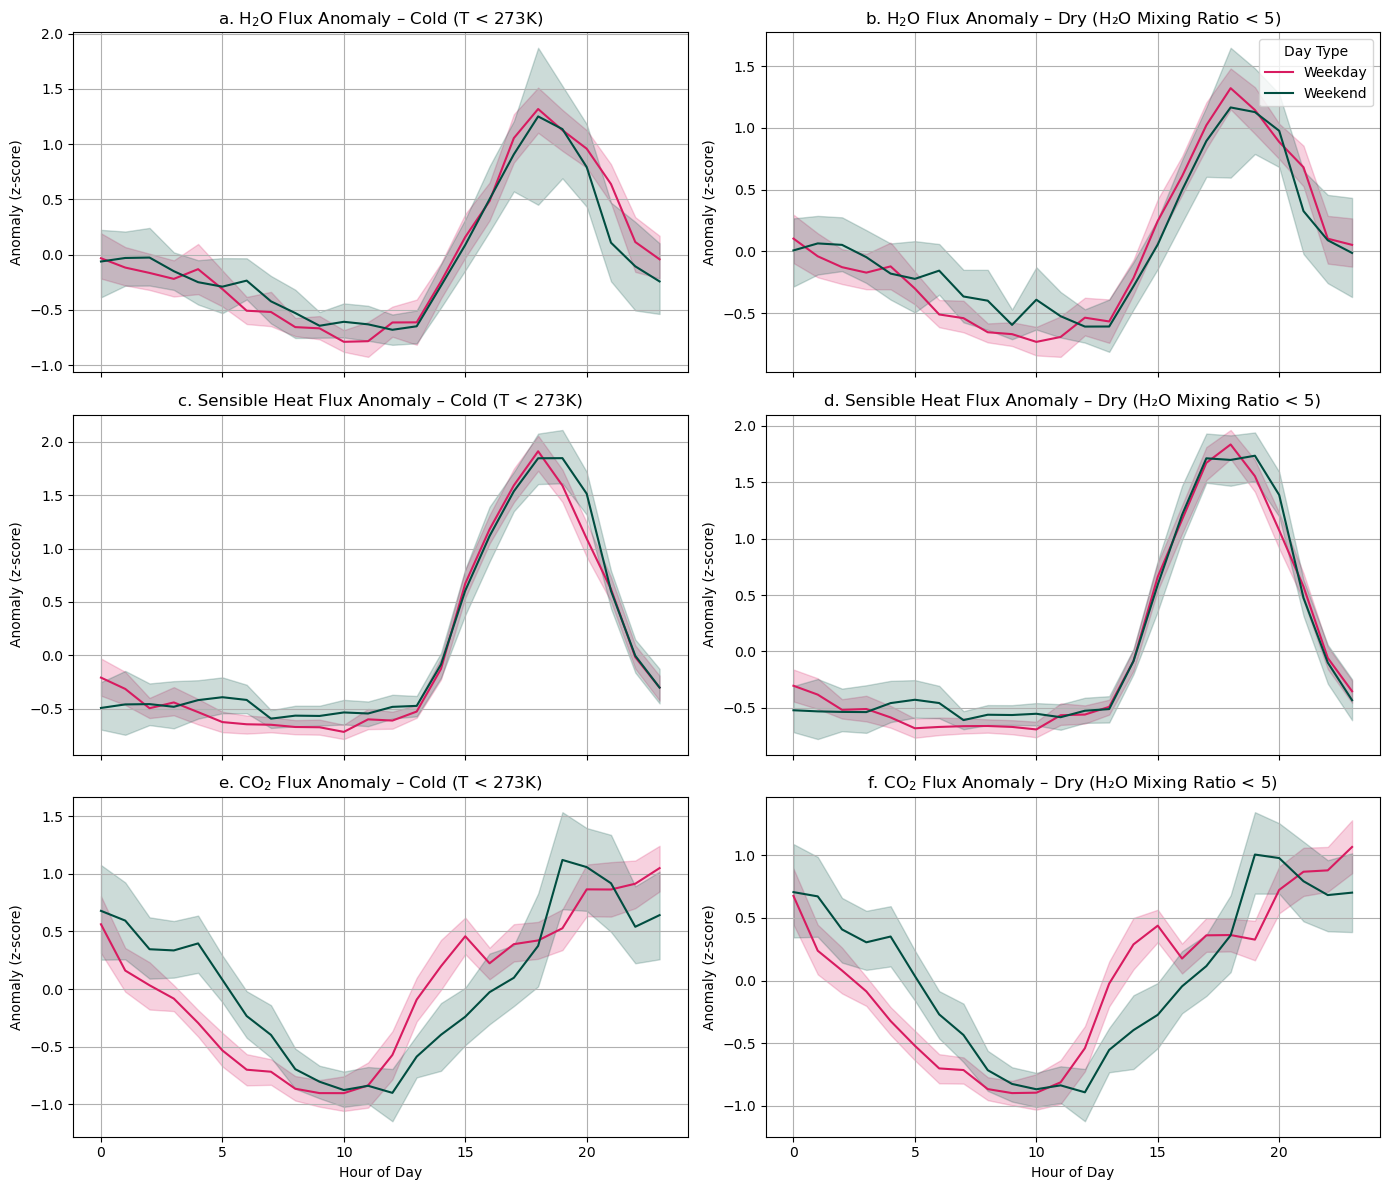

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_winter_anomaly_panels():
    # Variables and labels
    flux_vars = ['h2o_flux_anomaly', 'H_anomaly', 'co2_flux_anomaly']
    flux_titles = {
        'h2o_flux_anomaly': r'$\mathrm{H_2O}$ Flux Anomaly',
        'H_anomaly': 'Sensible Heat Flux Anomaly',
        'co2_flux_anomaly': r'$\mathrm{CO_2}$ Flux Anomaly'
    }
    col_titles = ['Cold (T < 273K)', 'Dry (H₂O Mixing Ratio < 5)']
    panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.']
    
    # Data subsets
    filters = [df_cold, df_dry]
    
    # Create figure
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)
    
    for row_idx, var in enumerate(flux_vars):
        for col_idx in range(2):
            ax = axes[row_idx, col_idx]
            subset = filters[col_idx]
            
            for is_weekend, group_df in subset.groupby('is_weekend'):
                label = 'Weekend' if is_weekend else 'Weekday'
                sns.lineplot(
                    data=group_df,
                    x='hour',
                    y=var,
                    label=label,
                    errorbar='ci',
                    ax=ax,
                    color=color_palette[label]
                )
            
            panel_idx = row_idx * 2 + col_idx
            ax.set_title(f"{panel_labels[panel_idx]} {flux_titles[var]} – {col_titles[col_idx]}")
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Anomaly (z-score)')
            ax.grid(True)
            
            if row_idx == 0 and col_idx == 1:
                ax.legend(title='Day Type', loc='upper right')
            else:
                ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

# Call the function
plot_winter_anomaly_panels()


### Recalculate Anomalies Based on DJF Mean & SD

In [8]:
# Compute DJF-wide mean and std for each flux variable
djf_mean_std = df_winter[['h2o_flux', 'H', 'co2_flux']].agg(['mean', 'std'])

# Apply z-score normalization using DJF-wide mean/std
for var in ['h2o_flux', 'H', 'co2_flux']:
    mean_val = djf_mean_std.loc['mean', var]
    std_val = djf_mean_std.loc['std', var]
    df_winter[f'{var}_djf_anomaly'] = (df_winter[var] - mean_val) / std_val

# Recreate cold and dry filtered subsets
df_cold = df_winter[df_winter['air_temperature'] < 273].copy()
df_dry = df_winter[df_winter['h2o_mixing_ratio'] < 5].copy()


#### Diurnal Anomaly Panels – DJF-Wide Normalization

Here, flux anomalies are normalized using the mean and standard deviation of the full DJF season.
This approach emphasizes systematic hourly departures from the seasonal average, allowing for robust comparison across hours and day types.
Clear weekday-weekend contrasts (especially during rush hours) help isolate anthropogenic signals.

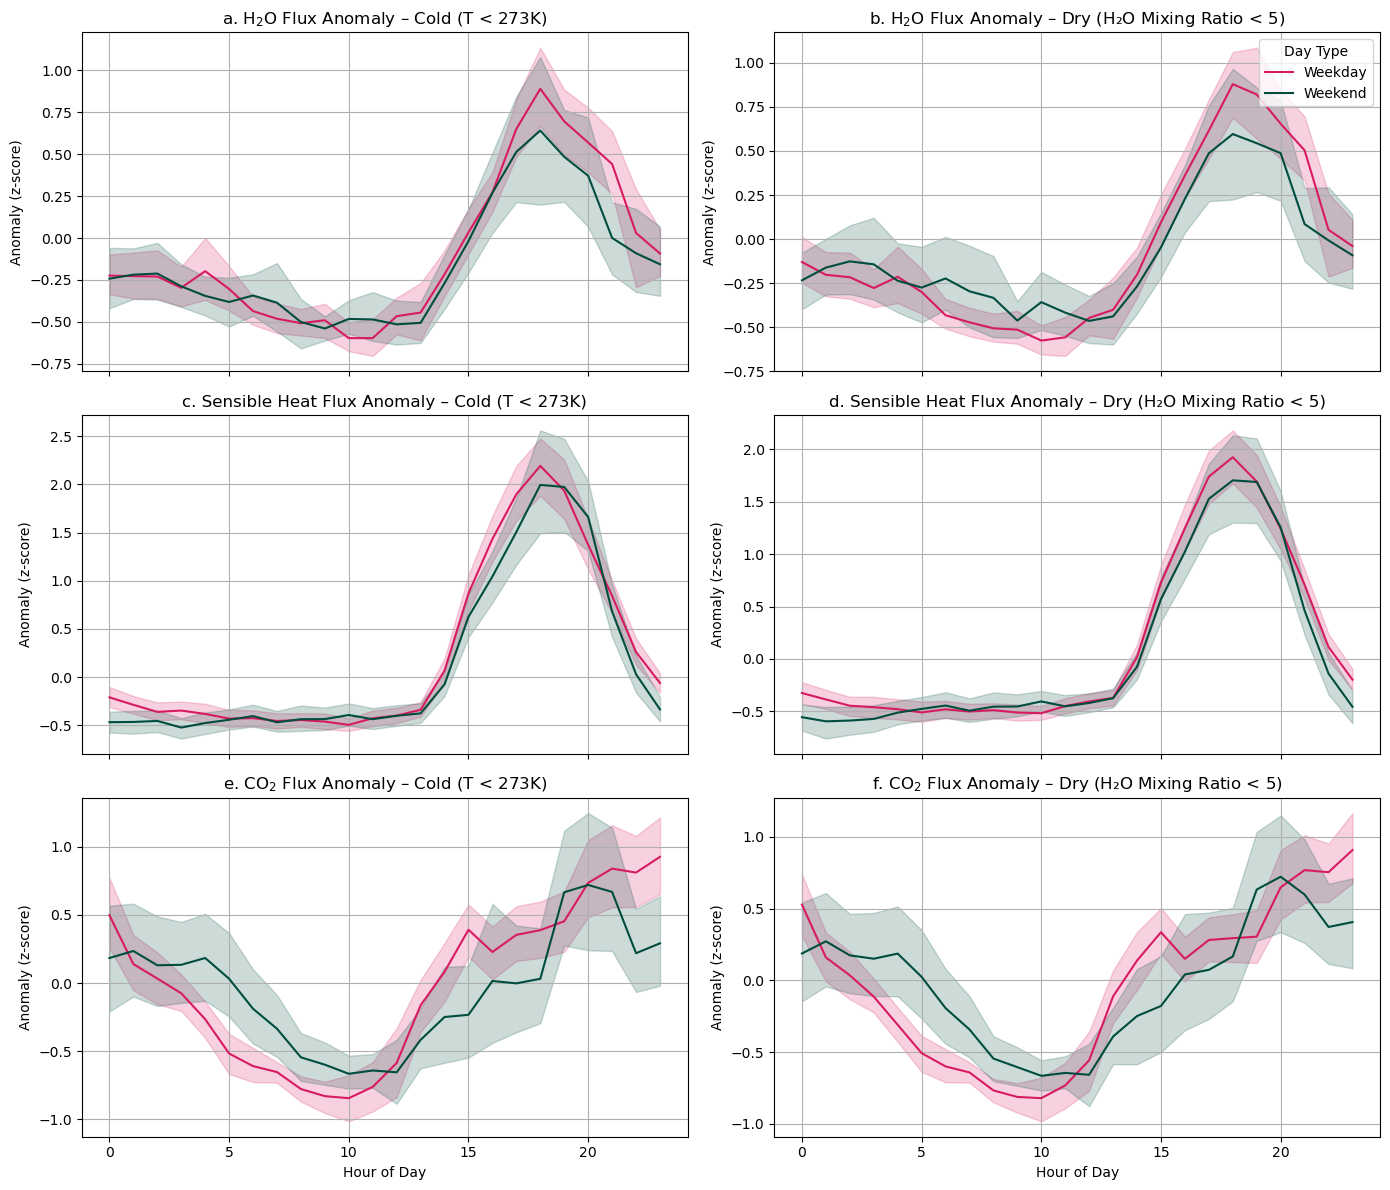

In [9]:
def plot_djf_anomaly_panels():
    flux_vars = ['h2o_flux_djf_anomaly', 'H_djf_anomaly', 'co2_flux_djf_anomaly']
    flux_titles = {
        'h2o_flux_djf_anomaly': r'$\mathrm{H_2O}$ Flux Anomaly',
        'H_djf_anomaly': 'Sensible Heat Flux Anomaly',
        'co2_flux_djf_anomaly': r'$\mathrm{CO_2}$ Flux Anomaly'
    }
    col_titles = ['Cold (T < 273K)', 'Dry (H₂O Mixing Ratio < 5)']
    panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.']
    filters = [df_cold, df_dry]

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)

    for row_idx, var in enumerate(flux_vars):
        for col_idx in range(2):
            ax = axes[row_idx, col_idx]
            subset = filters[col_idx]
            for is_weekend, group_df in subset.groupby('is_weekend'):
                label = 'Weekend' if is_weekend else 'Weekday'
                sns.lineplot(
                    data=group_df,
                    x='hour',
                    y=var,
                    label=label,
                    errorbar='ci',
                    ax=ax,
                    color=color_palette[label]
                )
            panel_idx = row_idx * 2 + col_idx
            ax.set_title(f"{panel_labels[panel_idx]} {flux_titles[var]} – {col_titles[col_idx]}")
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel('Anomaly (z-score)')
            ax.grid(True)
            if row_idx == 0 and col_idx == 1:
                ax.legend(title='Day Type', loc='upper right')
            else:
                ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

# Run the plot
plot_djf_anomaly_panels()


### CO₂-H₂O Flux Decoupling Index

In [10]:
# Flux decoupling index: ratio of CO2 to H2O flux
df['flux_ratio'] = df['co2_flux'] / df['h2o_flux']
df['flux_ratio'] = df['flux_ratio'].replace([np.inf, -np.inf], np.nan)


#### CO₂/H₂O Flux Decoupling Panels

These panels show the ratio of CO₂ flux to H₂O flux, highlighting potential decoupling between carbon and water cycling.
Under cold or dry conditions, combustion may continue (high CO₂) while transpiration slows (low H₂O), resulting in elevated ratios.
Clear morning/evening peaks on weekdays suggest influence from traffic-related emissions.

ValueError: Could not interpret value `flux_ratio` for `y`. An entry with this name does not appear in `data`.

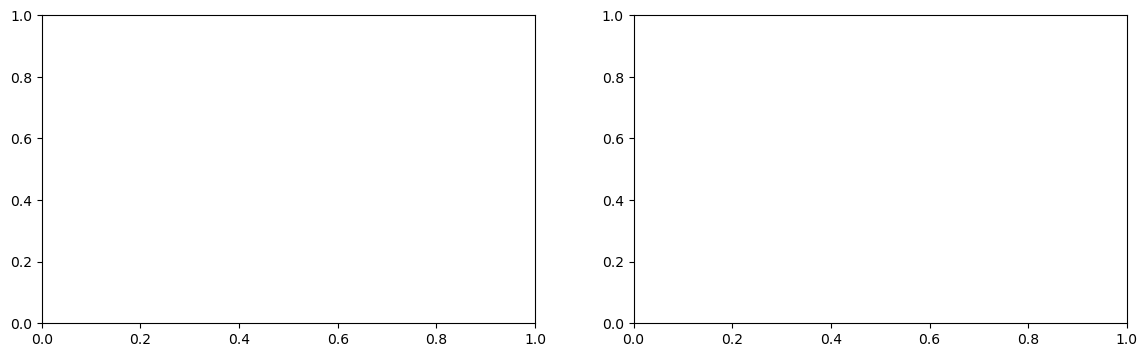

In [11]:
def plot_flux_ratio_panels():
    panel_labels = ['a.', 'b.']
    col_titles = ['Cold (T < 273K)', 'Dry (H₂O Mixing Ratio < 5)']
    filters = [df_cold, df_dry]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

    for col_idx in range(2):
        ax = axes[col_idx]
        subset = filters[col_idx]

        for is_weekend, group_df in subset.groupby('is_weekend'):
            label = 'Weekend' if is_weekend else 'Weekday'
            sns.lineplot(
                data=group_df,
                x='hour',
                y='flux_ratio',
                label=label,
                errorbar='ci',
                ax=ax,
                color=color_palette[label]
            )

        ax.set_title(f"{panel_labels[col_idx]} CO₂/H₂O Flux Ratio – {col_titles[col_idx]}")
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Flux Ratio (CO₂ / H₂O)')
        ax.grid(True)

        if col_idx == 1:
            ax.legend(title='Day Type', loc='upper right')
        else:
            ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

# Run the plot
plot_flux_ratio_panels()


### Stability & Turbulence Filtering

In [ ]:

# # Obukhov stability classification
df['stability'] = 'neutral'
df.loc[df['L'] > 100, 'stability'] = 'stable'
df.loc[df['L'] < -100, 'stability'] = 'unstable'

# Turbulence classification using u*
df['turbulence'] = 'low'
df.loc[df['u*'] >= 0.3, 'turbulence'] = 'high'


#### Stability and Turbulence Panels

Diurnal flux patterns grouped by:

    Stability (Obukhov length L): stable, neutral, unstable

    Turbulence (u*): low (< 0.3), high (≥ 0.3)
    Stable and low-turbulence periods suppress flux magnitudes and structure, likely due to weak vertical mixing.
    Unstable/high-turbulence conditions restore clearer diurnal signals, improving surface-atmosphere coupling.



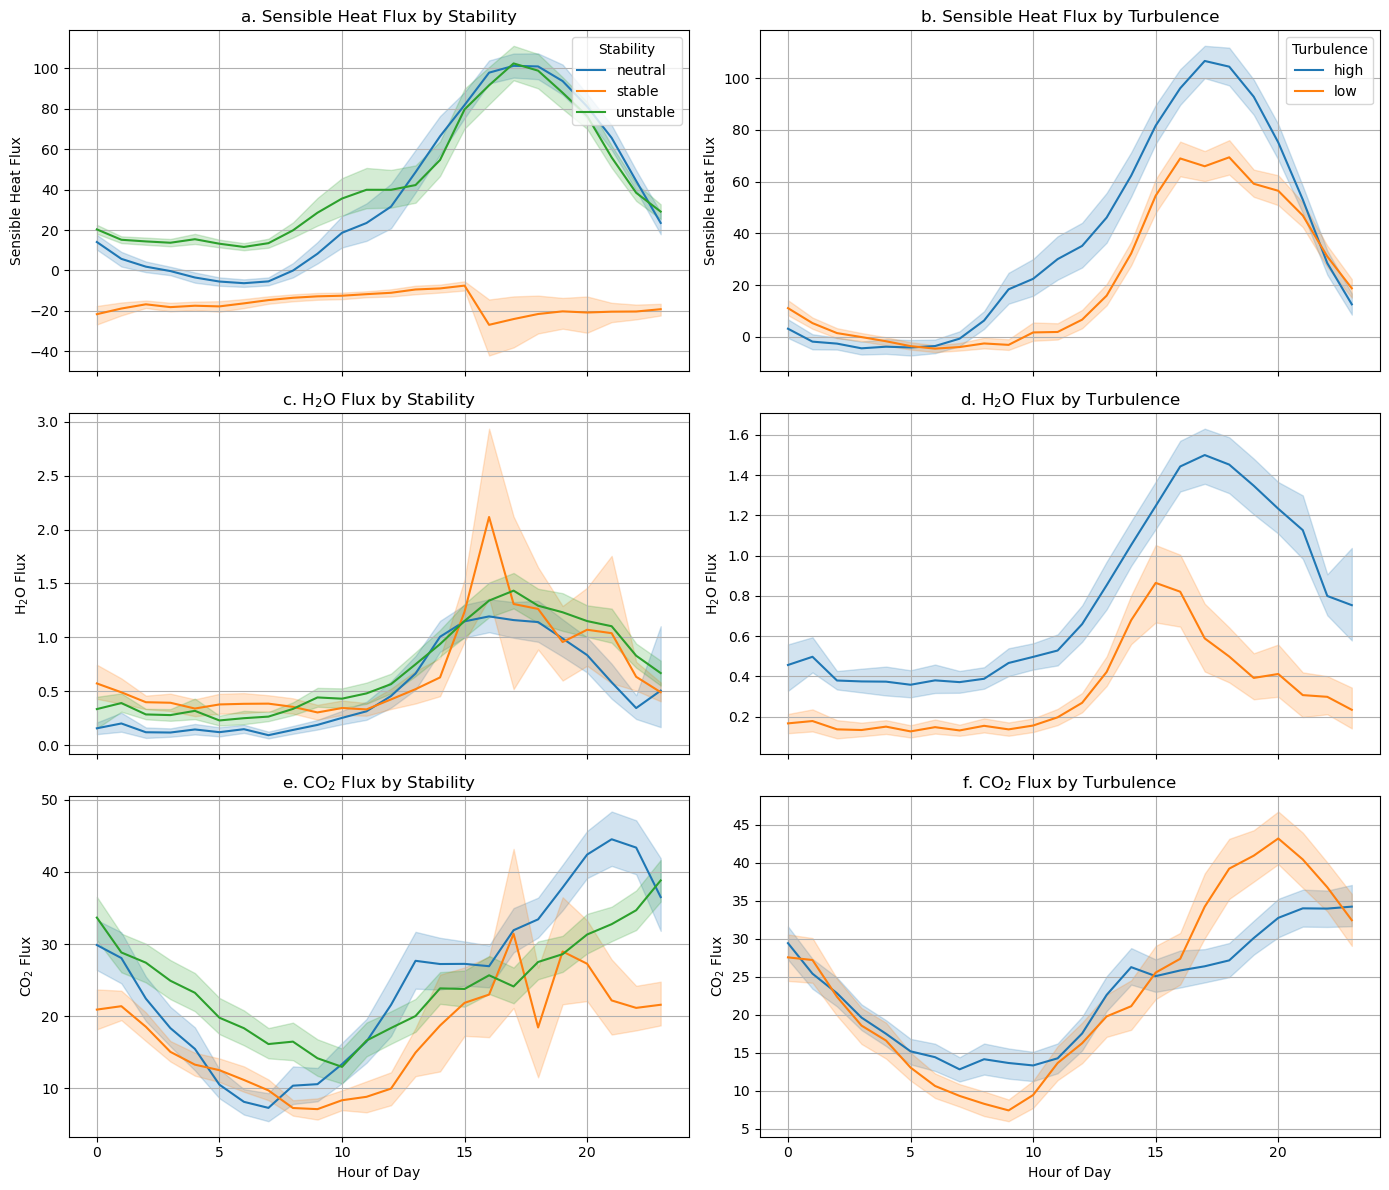

In [ ]:
def plot_stability_turbulence_panels():
    flux_vars = ['H', 'h2o_flux', 'co2_flux']
    flux_titles = {
        'H': 'Sensible Heat Flux',
        'h2o_flux': r'$\mathrm{H_2O}$ Flux',
        'co2_flux': r'$\mathrm{CO_2}$ Flux'
    }
    panel_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.']

    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12), sharex=True)

    for row_idx, var in enumerate(flux_vars):
        for col_idx, group_key in enumerate(['stability', 'turbulence']):
            ax = axes[row_idx, col_idx]
            for category, group_df in df.groupby(group_key):
                sns.lineplot(
                    data=group_df,
                    x='hour',
                    y=var,
                    errorbar='ci',  # changed from 'iqr'
                    ax=ax,
                    label=category
                )
            title_prefix = panel_labels[row_idx * 2 + col_idx]
            label = 'Stability' if group_key == 'stability' else 'Turbulence'
            ax.set_title(f"{title_prefix} {flux_titles[var]} by {label}")
            ax.set_xlabel('Hour of Day')
            ax.set_ylabel(flux_titles[var])
            ax.grid(True)
            if row_idx == 0:
                ax.legend(title=label, loc='upper right')
            else:
                ax.get_legend().remove()

    plt.tight_layout()
    plt.show()

# Run the updated plot
plot_stability_turbulence_panels()


### Condition-Based Summary Tables

This table summarizes flux behavior under different conditions (cold, dry, cold+dry, weekend, and baseline normal).
Reported values include:

    Median flux

    Interquartile range (25th–75th percentile)

    Sample size (n)

    Percentage of total observations
    Useful for statistical reporting or manuscript supplements.

In [ ]:
# Define flags
df['cold'] = df['air_temperature'] < 273
df['dry'] = df['h2o_mixing_ratio'] < 5

# Define condition label
df['condition'] = 'normal'
df.loc[df['cold'], 'condition'] = 'cold'
df.loc[df['dry'], 'condition'] = 'dry'
df.loc[df['cold'] & df['dry'], 'condition'] = 'cold+dry'
df.loc[df['is_weekend'], 'condition'] = 'weekend'
df['condition'] = df['condition'].astype('category')

# Summary table: median, IQR, count
summary = (
    df.groupby('condition')[['h2o_flux', 'H', 'co2_flux']]
    .agg([
        'median',
        lambda x: x.quantile(0.25),
        lambda x: x.quantile(0.75),
        'count'
    ])
)

# Format table
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary['total_n'] = len(df)
summary['percent_of_total'] = 100 * summary['co2_flux_count'] / summary['total_n']
summary.drop(columns='total_n', inplace=True)

# Show the table
summary


/var/folders/c0/hb5cyy892hqdjht868lw3qk80000gp/T/ipykernel_79097/1904086062.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('condition')[['h2o_flux', 'H', 'co2_flux']]


,h2o_flux_median,h2o_flux_<lambda_0>,h2o_flux_<lambda_1>,h2o_flux_count,H_median,H_<lambda_0>,H_<lambda_1>,H_count,co2_flux_median,co2_flux_<lambda_0>,co2_flux_<lambda_1>,co2_flux_count,percent_of_total
condition,,,,,,,,,,,,,
cold,0.344749,0.080895,0.608602,2,1.808660,1.423635,2.193685,2,12.31900,11.878800,12.759200,2,0.015507
cold+dry,0.167972,0.084285,0.304496,1830,17.766600,0.798044,49.614775,1830,15.92465,6.781930,30.503725,1830,14.189346
dry,0.242992,0.121368,0.461232,899,17.299900,-3.812705,66.315050,899,22.72760,11.634050,42.088800,899,6.970613
normal,0.363917,0.112045,1.047793,6522,9.090835,-7.606383,50.806175,6522,17.21050,6.781925,35.458550,6522,50.569900
weekend,0.262877,0.104415,0.664751,3644,10.784850,-4.975285,47.298350,3644,15.53265,5.793588,32.707925,3644,28.254633
